In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf 
from tensorflow import keras
from keras import Input
from keras import layers
import utils
import rbf_layer
from scipy.spatial import distance

# ---------------------------------------------------------------------------- #
#                                   read data                                  #
# ---------------------------------------------------------------------------- #

# data = "http://lib.stat.cmu.edu/datasets/boston"
data = "boston.csv"
raw_df = pd.read_csv(data, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]
print("Inputs:")
utils.data_summary(X)
print("Outputs:")
utils.data_summary(y)

Inputs:
Shape = (506, 13)
Minimum = 0.0
Maximum = 711.0
Range = 711.0
Variance = 21070.130450709916
Standard Deviation = 145.1555388220164

Outputs:
Shape = (506,)
Minimum = 5.0
Maximum = 50.0
Range = 45.0
Variance = 84.41955615616556
Standard Deviation = 9.188011545278203



In [2]:
# ---------------------------------------------------------------------------- #
#                                normalize data                                #
# ---------------------------------------------------------------------------- #

preprocessing.scale(X, copy=False, axis=0)
# preprocessing.scale(y, copy=False)
print("Normalized Inputs:")
utils.data_summary(X)
print(np.std(X[:,0]))

Normalized Inputs:
Shape = (506, 13)
Minimum = -3.9071933049810412
Maximum = 9.933930601860267
Range = 13.841123906841307
Variance = 1.0
Standard Deviation = 1.0

1.0


In [3]:
# ---------------------------------------------------------------------------- #
#                      split data to training and testing                      #
# ---------------------------------------------------------------------------- #

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Training Inputs:")
utils.data_summary(X_train)
print("Testing Inputs:")
utils.data_summary(X_test)

print("Training Outputs:")
utils.data_summary(y_train)
print("Testing Outputs:")
utils.data_summary(y_test)

n_train = X_train.shape[0]

Training Inputs:
Shape = (404, 13)
Minimum = -3.9071933049810412
Maximum = 9.933930601860267
Range = 13.841123906841307
Variance = 0.9948683723560822
Standard Deviation = 0.9974308860046807

Testing Inputs:
Shape = (102, 13)
Minimum = -3.8821945679249596
Maximum = 8.136883506576424
Range = 12.019078074501383
Variance = 1.0203003801045392
Standard Deviation = 1.0100991932006178

Training Outputs:
Shape = (404,)
Minimum = 5.0
Maximum = 50.0
Range = 45.0
Variance = 85.1437202235075
Standard Deviation = 9.227335488834656

Testing Outputs:
Shape = (102,)
Minimum = 5.6
Maximum = 50.0
Range = 44.4
Variance = 81.42843906189927
Standard Deviation = 9.02377077844397



In [20]:
# ---------------------------------------------------------------------------- #
#                          neural network construction                         #
# ---------------------------------------------------------------------------- #

# hidden_size = int(0.1 * n_train)
hidden_size = int(0.5 * n_train)
# hidden_size = int(0.9 * n_train)

model = keras.Sequential()
model.add(Input(shape=(13,)))
model.add(rbf_layer.RBF(hidden_size, utils.InitCentersKMeans(X_train)))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(1, activation="relu"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_1 (RBF)                 (None, 202)               2626      
                                                                 
 dense_2 (Dense)             (None, 128)               25984     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 28,739
Trainable params: 26,113
Non-trainable params: 2,626
_________________________________________________________________


In [21]:
# ---------------------------------------------------------------------------- #
#                            neural network training                           #
# ---------------------------------------------------------------------------- #

opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[utils.root_mean_squared_error, utils.coeff_determination])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
13/13 [==============================] - 1s 24ms/step - loss: 578.9603 - root_mean_squared_error: 23.9802 - coeff_determination: -6.6747 - val_loss: 532.4929 - val_root_mean_squared_error: 22.3359 - val_coeff_determination: -7.4111
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 524.0999 - root_mean_squared_error: 22.7577 - coeff_determination: -5.9817 - val_loss: 462.2419 - val_root_mean_squared_error: 20.7400 - val_coeff_determination: -6.1979
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 431.8028 - root_mean_squared_error: 20.7946 - coeff_determination: -4.4374 - val_loss: 342.7231 - val_root_mean_squared_error: 17.7043 - val_coeff_determination: -4.1488
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 291.3524 - root_mean_squared_error: 16.8665 - coeff_determination: -2.5728 - val_loss: 198.9799 - val_root_mean_squared_error: 13.1880 - val_coeff_determination: -1.7362
Epoch 5/100
13/13 [========

4/4 [==============================] - 0s 3ms/step - loss: 53.3500 - root_mean_squared_error: 6.7355 - coeff_determination: 0.2971


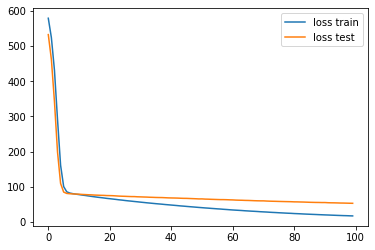

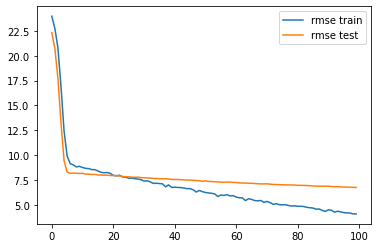

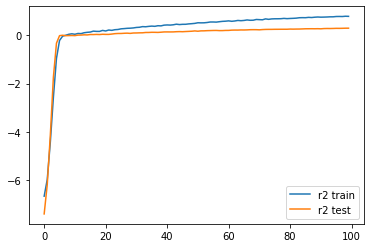

In [22]:
# ---------------------------------------------------------------------------- #
#                                    results                                   #
# ---------------------------------------------------------------------------- #

train_results = model.evaluate(X_train, y_train)
test_results = model.evaluate(X_test, y_test)
# print(train_results)
# print(test_results)

loss_train = history.history["loss"]
loss_test = history.history["val_loss"]

rmse_train = history.history["root_mean_squared_error"]
rmse_test = history.history["val_root_mean_squared_error"]

r2_train = history.history["coeff_determination"]
r2_test = history.history["val_coeff_determination"]

plt.plot(loss_train, label="loss train")
plt.plot(loss_test, label="loss test")
plt.legend()
plt.show()

plt.plot(rmse_train, label="rmse train")
plt.plot(rmse_test, label="rmse test")
plt.legend()
plt.show()

plt.plot(r2_train, label="r2 train")
plt.plot(r2_test, label="r2 test")
plt.legend()
plt.show()

In [39]:
# ---------------------------------------------------------------------------- #
#                                  fine tuning                                 #
# ---------------------------------------------------------------------------- #

import keras_tuner

def build_model(hp):
    model = keras.Sequential()
    model.add(Input(shape=(13,)))
    model.add(rbf_layer.RBF(num_units=hp.Choice("num_units", [int(0.05 * n_train), int(0.15 * n_train), int(0.3 * n_train), int(0.5 * n_train)]), centers_initializer=utils.InitCentersKMeans(X_train)))
    model.add(keras.layers.Dense(units=hp.Choice("units", [32, 64, 128, 256]), activation="relu"))
    model.add(keras.layers.Dense(1, activation="relu"))
    opt = keras.optimizers.SGD(learning_rate=0.001)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[utils.root_mean_squared_error, utils.coeff_determination])
    return model

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
num_units (Choice)
{'default': 20, 'conditions': [], 'values': [20, 60, 121, 202], 'ordered': True}
units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}


In [66]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [67]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf (RBF)                   (None, 202)               2626      
                                                                 
 dense (Dense)               (None, 256)               51968     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 54,851
Trainable params: 52,225
Non-trainable params: 2,626
_________________________________________________________________


In [68]:
history = best_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
13/13 [==============================] - 0s 13ms/step - loss: 16.5215 - root_mean_squared_error: 4.0100 - coeff_determination: 0.7956 - val_loss: 52.3838 - val_root_mean_squared_error: 6.6356 - val_coeff_determination: 0.3223
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 16.2607 - root_mean_squared_error: 4.0101 - coeff_determination: 0.8048 - val_loss: 52.2924 - val_root_mean_squared_error: 6.6347 - val_coeff_determination: 0.3215
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 16.0486 - root_mean_squared_error: 3.9362 - coeff_determination: 0.7959 - val_loss: 52.1176 - val_root_mean_squared_error: 6.6251 - val_coeff_determination: 0.3231
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 15.7356 - root_mean_squared_error: 3.8741 - coeff_determination: 0.8064 - val_loss: 51.9107 - val_root_mean_squared_error: 6.6115 - val_coeff_determination: 0.3260
Epoch 5/100
13/13 [==============================] 

In [69]:
# ---------------------------------------------------------------------------- #
#                                    results                                   #
# ---------------------------------------------------------------------------- #

train_results = best_model.evaluate(X_train, y_train)
test_results = best_model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 43.3802 - root_mean_squared_error: 6.0094 - coeff_determination: 0.4417
